# Load all packages

In [1]:
import xarray as xr
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Polygon
from scipy.stats import pearsonr
import geopandas as gpd
import sys
from mpl_toolkits.basemap import Basemap
import pyproj
from pyproj import Proj, transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

import scipy.stats as st 

In [2]:
# Define the source and target CRS
src_crs = Proj('EPSG:4326')
target_crs = Proj(proj='latlong', datum='WGS84')

# Now, use lon_values_reprojected and lat_values_reprojected in your plt.imshow() and shapefile plotting functions

# Load the shapefile using geopandas
shapefile_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/dangermond_bound/dan_bound2.shp"
gdf = gpd.read_file(shapefile_path)


target_date= 1645660800.0
target_date= 2022-02-24 00:00:00
<xarray.Dataset> Size: 9MB
Dimensions:         (lat: 458, lon: 492, nbnd: 2)
Coordinates:
  * lat             (lat) float64 4kB 34.44 34.44 34.44 ... 34.58 34.58 34.58
  * lon             (lon) float64 4kB -120.5 -120.5 -120.5 ... -120.4 -120.4
    time            datetime64[ns] 8B 2022-02-24
Dimensions without coordinates: nbnd
Data variables: (12/13)
    lat_bnds        (lat, nbnd) float64 7kB ...
    lon_bnds        (lon, nbnd) float64 8kB ...
    gw              (lat) float64 4kB ...
    area            (lat, lon) float64 2MB ...
    cloud_fraction  (lat, lon) float32 901kB ...
    dcCorr          (lat, lon) float32 901kB ...
    ...              ...
    phase_angle     (lat, lon) float32 901kB ...
    sif             (lat, lon) float32 901kB ...
    sif_dc          (lat, lon) float32 901kB ...
    sif_relative    (lat, lon) float32 901kB ...
    sif_sigma       (lat, lon) float32 901kB ...
    spatial_ref     int64 8B ...


KeyboardInterrupt: 

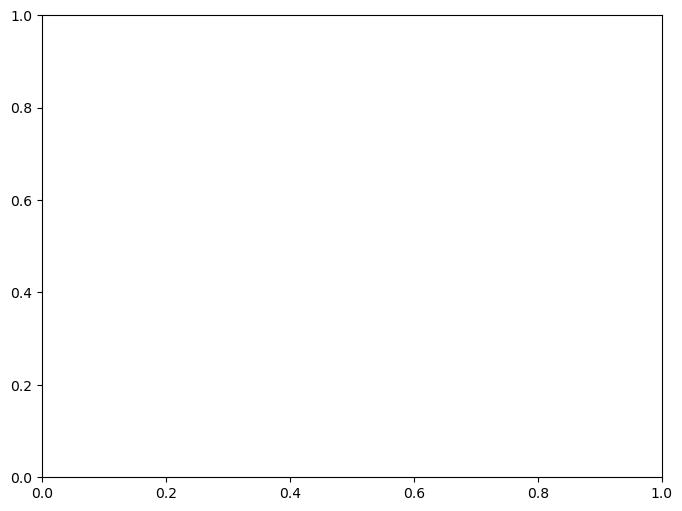

In [3]:
# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file path
#base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax.nc"
base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{}_clima_fit_reg_jmax.nc"

# Open the NetCDF file for TROPOMI dataset
file2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.001deg_regrid_Dangermond_tll_clipped_458_492.nc"
ds2 = xr.open_dataset(file2, decode_times=True)

# Save dates, mean, and std values to a text file
try:
    file = open('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/sif_statistics_hr_clima_fit.txt', 'w')
    file.write('Date\tMean Observed\tStd Observed\tCI95 Observed\tMean Predicted\tStd Predicted\tCI95 Predicted\n')
except Exception as e:
    print(f"Error: {e}")


# Initialize empty lists to accumulate data points
observed_all = []
predicted_all = []

# Initialize a list to store individual spatial differences
spatial_diff_list = []

for i, target_date_str in enumerate(dates):
    # Construct file1 dynamically based on the time step index (i)
    file1 = base_file_path.format(str(i).zfill(2))

    # Open dataset for file1
    ds1 = xr.open_dataset(file1, decode_times=False)  
    
    target_date = pd.Timestamp(target_date_str).value / 10**9  # Convert to seconds since epoch
    print('target_date=',target_date)
    # Convert target_date to datetime64[ns]
    target_date = pd.to_datetime(target_date, unit='s')
    print('target_date=',target_date)

    # Define a time range for a week centered around the target date
    start_date = target_date - pd.Timedelta(days=3)  # 3 days before the target date
    end_date = target_date + pd.Timedelta(days=3)    # 3 days after the target date

    # Select the data from the dataset with multiple times based on the specific date
    ds2_selected = ds2.sel(time=target_date, method="nearest")
    print(ds2_selected)
    
    # Select the data from ds2 within the specified time range
    ds2_selected = ds2.sel(time=slice(start_date, end_date))
    ds2_selected = ds2_selected.mean(dim='time', skipna=True)
    print(ds2_selected)
    #sys.exit()

    # Calculate the average time of the selected data in ds2_selected

    ds1_selected = ds1['sif740']
    
    # Filter out NaN values
    valid_indices = ~np.isnan(ds2_selected['sif'].values.flatten()) & ~np.isnan(ds1_selected.values.flatten())
    if valid_indices.any():
        observed = ds2_selected['sif'].values.flatten()[valid_indices]
        predicted = ds1_selected.values.flatten()[valid_indices]
        
        print("Observed shape before cleaning:", observed.shape)
        print("Predicted shape before cleaning:", predicted.shape)

        observed = observed[~np.isnan(observed)]
        predicted = predicted[~np.isnan(predicted)]

        print("Observed shape after cleaning:", observed.shape)
        print("Predicted shape after cleaning:", predicted.shape)


        print('mean obs =', np.mean(observed))
        print('mean pred =', np.mean(predicted))

        # Calculate spatial differences
        spatial_diff_num =  predicted 

        # Squeeze the array to remove the singleton dimension
        spatial_diff_num = np.squeeze(spatial_diff_num)   
        
        # Calculate spatial differences
        spatial_diff =  ds1_selected.values
        
        # Squeeze the array to remove the singleton dimension
        spatial_diff = np.squeeze(spatial_diff)
        
        
        # Calculate spatial differences and append them to the list
        spatial_diff_list.append(spatial_diff)

        #Get latitude and longitude values
        lat_values = ds2_selected['lat'].values
        lon_values = ds2_selected['lon'].values
        
        # Calculate metrics
        mae = mean_absolute_error(observed, predicted)

        # Calculate mean, std, bias, RMSE, and R²
        mean_observed = np.mean(observed)
        mean_predicted = np.mean(predicted)
        std_observed = np.std(observed)
        std_predicted = np.std(predicted)
        bias = mean_predicted - mean_observed
        rmse = np.sqrt(np.mean((predicted - observed)**2))
        slope, intercept, r_value, p_value, std_err = linregress(observed, predicted)
        r2 = r_value**2


        
        #plt.imshow(spatial_diff)
        #plt.colorbar()
        #plt.show()
        #plt.close()
        print("mae:", mae)
        print("bias:", bias)
        print("RMSE:", rmse)
        print("R^2 Score:", r2)

        # create 95% confidence interval 
        ci95_observed = st.t.interval(0.95, df=len(observed)-1, 
                        loc=np.mean(observed), 
                        scale=st.sem(observed)) 

        # create 95% confidence interval 
        ci95_predicted = st.t.interval(0.95, df=len(predicted)-1, 
                        loc=np.mean(predicted), 
                        scale=st.sem(predicted)) 
  
        # Append statistics for the current date to the file
        file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted}\t{bias}\t{rmse}\t{r2}\n')

        # Create a Basemap instance with the desired projection
        m = Basemap(projection='merc', llcrnrlat=lat_values.min(), urcrnrlat=lat_values.max(),
                llcrnrlon=lon_values.min(), urcrnrlon=lon_values.max(), resolution='c')

        x,y = np.meshgrid(lon_values, lat_values) 
        X,Y = m(x, y)
        
        # Define the number of decimal places for meridian and parallel labels
        decimal_places = 3

        # Define a custom formatter function to format the labels with the specified number of decimal places
        def format_labels(x, pos):
            return '{:.{decimal_places}f}'.format(x, decimal_places=decimal_places)


        # Create a figure and axes
        plt.figure(figsize=(8, 6))
        m.drawparallels(np.arange(-90.,91.,0.025), labels=[1,0,0,1],    dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        m.drawmeridians(np.arange(0., 360., 0.025), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        #m.drawcoastlines(color='0.6', linewidth=0.5)

        # Plot spatial differences using pcolormesh with Basemap
        cs = m.pcolormesh(X, Y, spatial_diff, cmap='YlGn', vmin=0, vmax=2.)

        vmin = 0.
        vmax = 2.
        cbar = m.colorbar(cs, pad='10%',ticks=np.linspace(vmin,vmax,6),format='%.2f')
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel(r'SIF$_{740nm}$ (W.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
        cbar.solids.set_edgecolor("face")
        #cbar.set_clim(vmin,vmax)
        # Assuming cbar is your Colorbar object
        #cbar.ax.set_clim(vmin, vmax)
        cbar.ax.tick_params(labelsize='large')
        #gdf.plot(ax=m, linewidth=1, edgecolor='black', facecolor='none', legend=True)
        #m.readshapefile(shapefile_path,'Geometry')
        # Plot contour of Dangermond shapefile
        #m.readshapefile(shapefile_path, 'dan_bound2', linewidth=2, color='black')
        
        # Manually draw shapefile polygons on top of the contour plot
        for shape in gdf['geometry']:
            if shape.geom_type == 'Polygon':
                x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
                polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
                plt.gca().add_patch(polygon)

        # Plot spatial differences with latitude and longitude values on the y and x axes
        #plt.imshow(spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data range
    
        # Overlay shapefile contour on top of the spatial differences plot
        #gdf.plot(ax=plt.gca(), linewidth=1, edgecolor='black', facecolor='none', legend=True)


        # Set title, labels, and tick formatters
        plt.title(f'Date {target_date_str}',fontsize=14)
        #plt.xlabel('Longitude')
        #plt.ylabel('Latitude')
    

        # Add colorbar to the right of the plot
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)


        
        # Set 2 decimal places for latitude and longitude ticks
        #lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lat_values[x]))
        #lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lon_values[x]))
        
        
        # Get latitude and longitude values from your SIF data
        #lat_min, lat_max = lat_values.min(), lat_values.max()
        #lon_min, lon_max = lon_values.min(), lon_values.max()
        #print( lon_min, lon_max,lat_min, lat_max)
        
        # Set 4 ticks for latitude and longitude
        #num_ticks = 4
        #lat_indices = np.linspace(0, len(lat_values) - 1, num_ticks, dtype=int)
        #lon_indices = np.linspace(0, len(lon_values) - 1, num_ticks, dtype=int)

        # Set x and y ticks with actual lat and lon values formatted to 2 decimal places
        #plt.xticks(lon_indices, lon_values[lon_indices])
        #plt.yticks(lat_indices, lat_values[lat_indices])

        # Set formatted latitude and longitude tick labels
        #plt.gca().get_xaxis().set_major_formatter(lon_formatter)
        #plt.gca().get_yaxis().set_major_formatter(lat_formatter)
        


        # Add text box with statistics in the upper right corner
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
        plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
                transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right',fontsize=14)
                


        # Invert the latitude axis
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        # Save the figure
        plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/sif740_{i}_hr_jmax_clima_fit.png',dpi=300)
        #plt.show()
        #sys.exit()
        
        # Close the figure to avoid displaying multiple plots at once
        plt.close()
        print('Figure spatial_differences_{i}.png saved!')
        

        # Filter out NaN values
        valid_indices = ~np.isnan(ds1_selected.values) & ~np.isnan(ds2_selected['sif'].values)
        observed = ds2_selected['sif'].values.reshape(-1)[valid_indices.reshape(-1)]
        predicted = ds1_selected.values.reshape(-1)[valid_indices.reshape(-1)]

        # Check if there are still valid values after filtering
        if len(observed) > 0 and len(predicted) > 0:
            # Accumulate observed and predicted values
            observed_all.extend(observed)
            predicted_all.extend(predicted)

        # Close the datasets to free up resources
        ds1.close()
        ds2_selected.close()
        
        print('Total matrix ammended!')
        print(spatial_diff_list)
    
    
# Calculate the average spatial difference after the loop
average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)  

# Create a figure and axes
plt.figure(figsize=(8, 6))
m.drawparallels(np.arange(-90., 91., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)
m.drawmeridians(np.arange(0., 360., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)

# Plot spatial differences using pcolormesh with Basemap
cs = m.pcolormesh(X, Y, average_spatial_diff, cmap='YlGn', vmin=0, vmax=2)

vmin = 0
vmax = 2
cbar = m.colorbar(cs, pad='10%', ticks=np.linspace(vmin, vmax, 6), format='%.2f')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'SIF$_{740nm}$ (W.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
cbar.solids.set_edgecolor("face")
cbar.ax.tick_params(labelsize='large')

# Manually draw shapefile polygons on top of the contour plot
for shape in gdf['geometry']:
    if shape.geom_type == 'Polygon':
       x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
       polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
       plt.gca().add_patch(polygon)

# Set title, labels, and tick formatters
plt.title(f'Mean', fontsize=14)

# Add text box with statistics in the upper right corner
bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
           transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right', fontsize=14)


plt.tight_layout()
# Save the figure
plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/sif740_mean_hr_jmax_clima_fit.png', dpi=300)


# Close the figure to avoid displaying multiple plots at once
plt.close()
print(f'Figure pft_spatial_differences_{i}.png saved!')
  


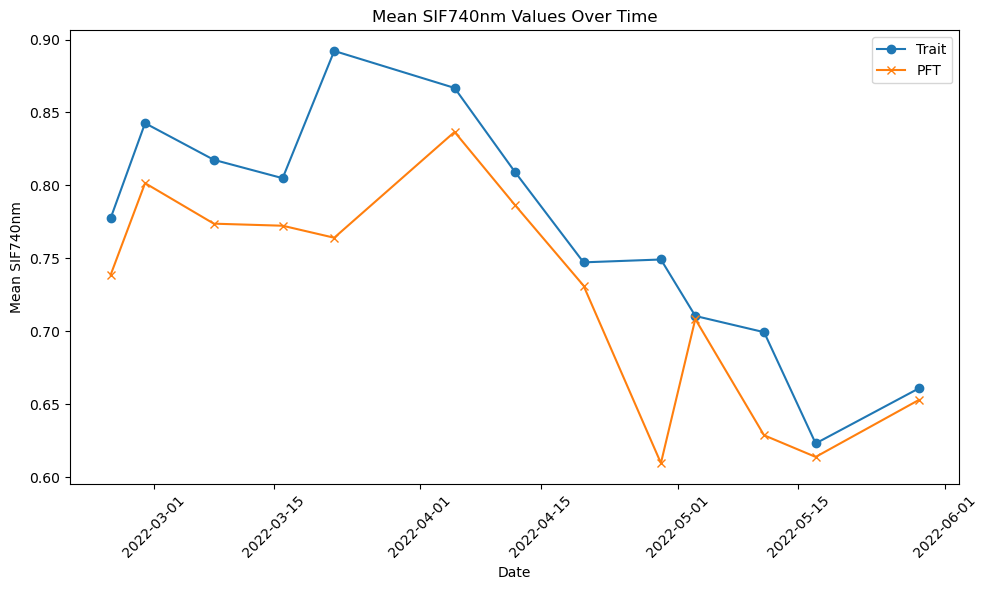

In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]


# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{}_clima_fit_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/pft_shift_fluxes_day_{}_clima_fit_reg_jmax.nc"

# Initialize lists to store mean Chl values for each dataset
mean_chl_trait = []
mean_chl_pft = []

# Convert string dates to pandas datetime objects
date_objects = [pd.to_datetime(date) for date in dates]

for i, date in enumerate(date_objects):
    file_trait = base_file_path_trait.format(str(i).zfill(2))
    file_pft = base_file_path_pft.format(str(i).zfill(2))

    # Open datasets
    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)

    # Extract Chl data and calculate mean, ignoring NaN values
    mean_chl_trait.append(ds_trait['sif740'].mean().values)
    mean_chl_pft.append(ds_pft['sif740'].mean().values)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(date_objects, mean_chl_trait, label='Trait', marker='o')
plt.plot(date_objects, mean_chl_pft, label='PFT', marker='x')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Mean SIF740nm')
plt.title('Mean SIF740nm Values Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/mean_sif740_over_time.png')
plt.show()


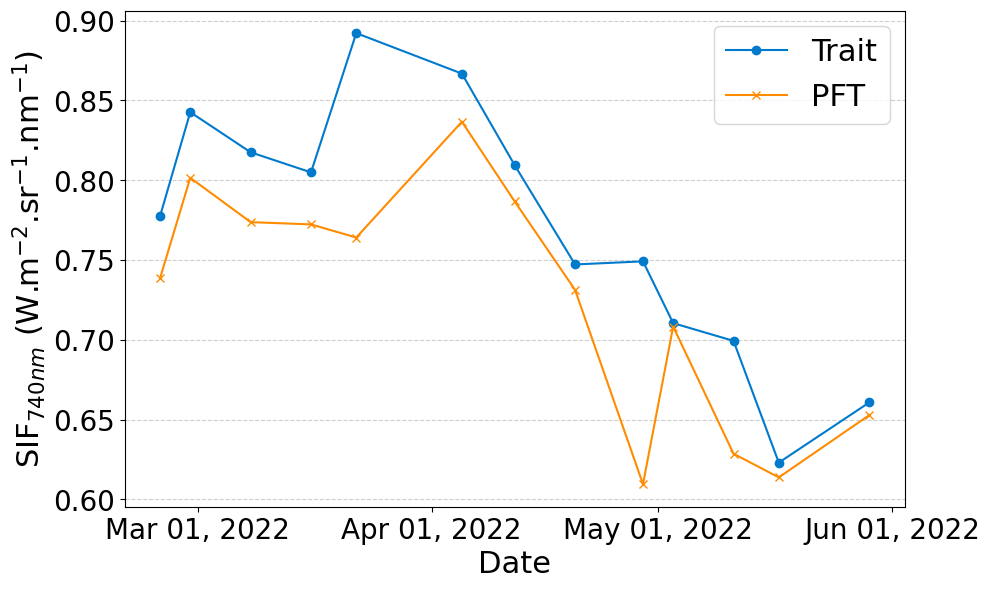

In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{}_clima_fit_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/pft_shift_fluxes_day_{}_clima_fit_reg_jmax.nc"

# Initialize lists to store mean SIF740 values for each dataset
mean_sif740_trait = []
mean_sif740_pft = []

# Convert string dates to pandas datetime objects
date_objects = [pd.to_datetime(date) for date in dates]

for i, date in enumerate(date_objects):
    file_trait = base_file_path_trait.format(str(i).zfill(2))
    file_pft = base_file_path_pft.format(str(i).zfill(2))

    # Open datasets
    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)

    # Extract SIF740 data and calculate mean, ignoring NaN values
    mean_sif740_trait.append(ds_trait['sif740'].mean().values)
    mean_sif740_pft.append(ds_pft['sif740'].mean().values)

# Create a custom color palette for the lines
trait_color = '#007acc'  # Blue color for "Trait"
pft_color = '#ff8c00'    # Orange color for "PFT"

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(date_objects, mean_sif740_trait, label='Trait', marker='o', color=trait_color)
ax.plot(date_objects, mean_sif740_pft, label='PFT', marker='x', color=pft_color)

# Formatting the plot
ax.set_xlabel('Date', fontsize=22)
ax.set_ylabel(r'SIF$_{740nm}$ (W.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', fontsize=22)

#ax.set_title('Mean SIF740nm Values Over Time', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Display month intervals on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Y"))  # Format x-axis date labels

# Customize legend
legend = ax.legend(loc='upper right', fontsize=22)
legend.get_lines()[0].set_color(trait_color)
legend.get_lines()[1].set_color(pft_color)

# Customize grid lines
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Save the plot with high DPI for publication
plt.tight_layout()
plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/mean_sif740_over_time_clima_fit.png', dpi=300)
plt.show()


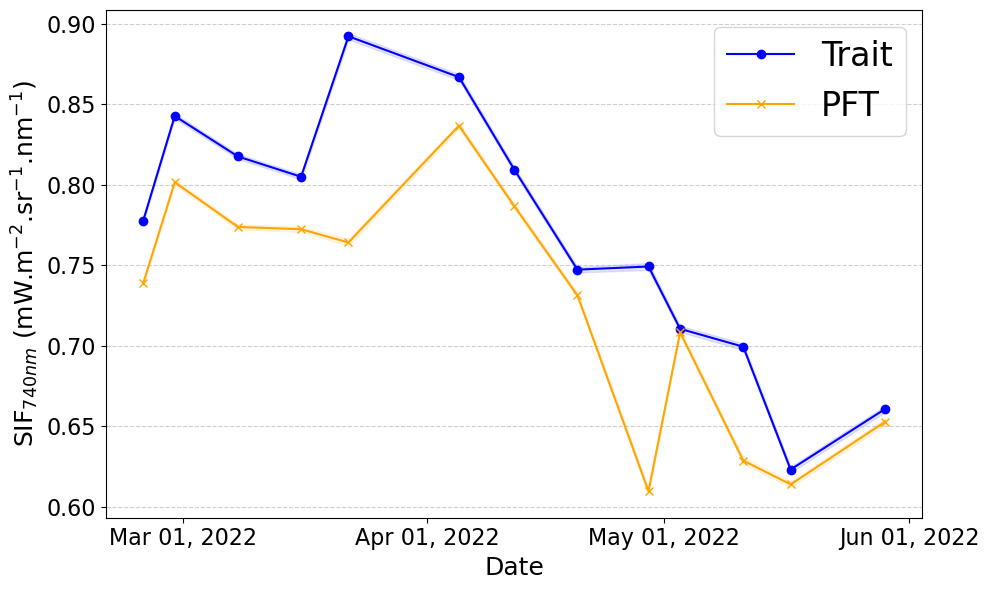

In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Function to calculate standard deviation area
def calc_std_area(data):
    std_hi = []
    std_lo = []

    mean = np.nanmean(data, axis=(1, 2))
    std = np.nanstd(data, axis=(1, 2))
    std_hi = mean + std
    std_lo = mean - std
    return std_lo, std_hi

# Function to calculate the 95% confidence interval
def calc_ci95(data):
    mean = np.nanmean(data, axis=(1, 2))
    std = np.nanstd(data, axis=(1, 2))
    count = np.sum(~np.isnan(data), axis=(1, 2))
    ci95_hi = mean + 1.99 * std / np.sqrt(count)
    ci95_lo = mean - 1.99 * std / np.sqrt(count)
    return ci95_lo, ci95_hi


# Given dates
dates = [
    "2022-02-24", "2022-02-28", "2022-03-08",
    "2022-03-16", "2022-03-22", "2022-04-05",
    "2022-04-12", "2022-04-20", "2022-04-29",
    "2022-05-03", "2022-05-11", "2022-05-17",
    "2022-05-29"
]

# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{}_clima_fit_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/pft_shift_fluxes_day_{}_clima_fit_reg_jmax.nc"

# Initialize lists to store data
mean_sif740_trait = []
mean_sif740_pft = []
std_hi_trait = []
std_lo_trait = []
std_hi_pft = []
std_lo_pft = []
ci95_hi_trait = []
ci95_lo_trait = []
ci95_hi_pft = []
ci95_lo_pft = []

# Convert string dates to pandas datetime objects
date_objects = pd.to_datetime(dates)

for i, date in enumerate(date_objects):
    file_trait = base_file_path_trait.format(str(i).zfill(2))
    file_pft = base_file_path_pft.format(str(i).zfill(2))

    # Open datasets
    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)

    # Calculate mean SIF740 and standard deviation area for Trait and PFT
    mean_sif740_trait.append(ds_trait['sif740'].mean(dim=['lat', 'lon']).values)
    mean_sif740_pft.append(ds_pft['sif740'].mean(dim=['lat', 'lon']).values)

    std_lo, std_hi = calc_std_area(ds_trait['sif740'].values)
    std_lo_trait.append(std_lo)
    std_hi_trait.append(std_hi)

    std_lo, std_hi = calc_std_area(ds_pft['sif740'].values)
    std_lo_pft.append(std_lo)
    std_hi_pft.append(std_hi)

    ci_lo_trait, ci_hi_trait = calc_ci95(ds_trait['sif740'].values)
    ci_lo_pft, ci_hi_pft = calc_ci95(ds_pft['sif740'].values)

    ci95_lo_trait.append(ci_lo_trait)
    ci95_hi_trait.append(ci_hi_trait)
    ci95_lo_pft.append(ci_lo_pft)
    ci95_hi_pft.append(ci_hi_pft)



# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(date_objects, mean_sif740_trait, label='Trait', marker='o', color='blue')
ax.plot(date_objects, mean_sif740_pft, label='PFT', marker='x', color='orange')

# Ensure that the std_lo and std_hi arrays are 1D by flattening them
std_lo_trait = np.array(std_lo_trait).flatten()
std_hi_trait = np.array(std_hi_trait).flatten()
std_lo_pft = np.array(std_lo_pft).flatten()
std_hi_pft = np.array(std_hi_pft).flatten()

# Ensure that the ci95_lo and ci95_hi arrays are 1D by flattening them
ci95_lo_trait = np.array(ci95_lo_trait).flatten()
ci95_hi_trait = np.array(ci95_hi_trait).flatten()
ci95_lo_pft = np.array(ci95_lo_pft).flatten()
ci95_hi_pft = np.array(ci95_hi_pft).flatten()

# Add shaded area for STD
#ax.fill_between(date_objects, std_lo_trait, std_hi_trait, color='blue', alpha=0.1)
#ax.fill_between(date_objects, std_lo_pft, std_hi_pft, color='orange', alpha=0.1)

# Add shaded area for ci95
ax.fill_between(date_objects, ci95_lo_trait, ci95_hi_trait, color='blue', alpha=0.1)
ax.fill_between(date_objects, ci95_lo_pft, ci95_hi_pft, color='orange', alpha=0.1)

# Formatting the plot
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel(r'SIF$_{740nm}$ (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Display month intervals on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Y"))  # Format x-axis date labels
ax.legend(loc='best', fontsize=24)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Save the plot with high DPI for publication
plt.tight_layout()
plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/mean_sif740_over_time_clima_fit_pub.png', dpi=300)
plt.show()


### Plotting SIF with TROPOMI

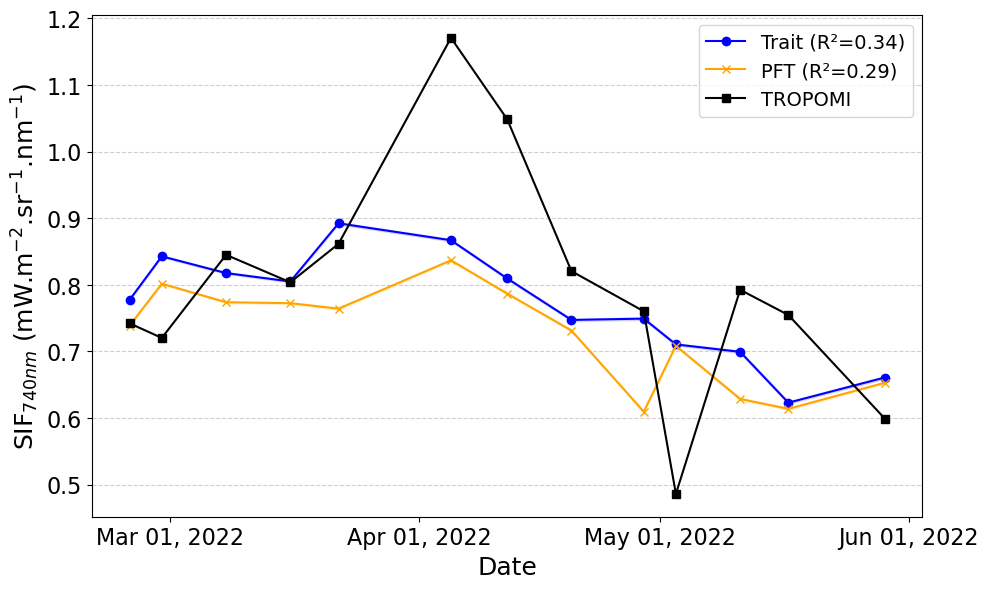

In [27]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import linregress

# Function to calculate standard deviation area
def calc_std_area(data):
    std_hi = []
    std_lo = []

    mean = np.nanmean(data, axis=(1, 2))
    std = np.nanstd(data, axis=(1, 2))
    std_hi = mean + std
    std_lo = mean - std
    return std_lo, std_hi

# Function to calculate the 95% confidence interval
def calc_ci95(data):
    mean = np.nanmean(data, axis=(1, 2))
    std = np.nanstd(data, axis=(1, 2))
    count = np.sum(~np.isnan(data), axis=(1, 2))
    ci95_hi = mean + 1.99 * std / np.sqrt(count)
    ci95_lo = mean - 1.99 * std / np.sqrt(count)
    return ci95_lo, ci95_hi


# Given dates
dates = [
    "2022-02-24", "2022-02-28", "2022-03-08",
    "2022-03-16", "2022-03-22", "2022-04-05",
    "2022-04-12", "2022-04-20", "2022-04-29",
    "2022-05-03", "2022-05-11", "2022-05-17",
    "2022-05-29"
]

# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{}_clima_fit_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/pft_shift_fluxes_day_{}_clima_fit_reg_jmax.nc"

# Initialize lists to store data
mean_sif740_trait = []
mean_sif740_pft = []
std_hi_trait = []
std_lo_trait = []
std_hi_pft = []
std_lo_pft = []
ci95_hi_trait = []
ci95_lo_trait = []
ci95_hi_pft = []
ci95_lo_pft = []

# Convert string dates to pandas datetime objects
date_objects = pd.to_datetime(dates)

for i, date in enumerate(date_objects):
    file_trait = base_file_path_trait.format(str(i).zfill(2))
    file_pft = base_file_path_pft.format(str(i).zfill(2))

    # Open datasets
    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)

    # Calculate mean SIF740 and standard deviation area for Trait and PFT
    mean_sif740_trait.append(ds_trait['sif740'].mean(dim=['lat', 'lon']).values.item())
    mean_sif740_pft.append(ds_pft['sif740'].mean(dim=['lat', 'lon']).values.item())

    std_lo, std_hi = calc_std_area(ds_trait['sif740'].values)
    std_lo_trait.append(std_lo)
    std_hi_trait.append(std_hi)

    std_lo, std_hi = calc_std_area(ds_pft['sif740'].values)
    std_lo_pft.append(std_lo)
    std_hi_pft.append(std_hi)

    ci_lo_trait, ci_hi_trait = calc_ci95(ds_trait['sif740'].values)
    ci_lo_pft, ci_hi_pft = calc_ci95(ds_pft['sif740'].values)

    ci95_lo_trait.append(ci_lo_trait)
    ci95_hi_trait.append(ci_hi_trait)
    ci95_lo_pft.append(ci_lo_pft)
    ci95_hi_pft.append(ci_hi_pft)

# TROPOMI data two weeks 001
#tropomi_sif = [0.821451545, 0.790074646, 0.886234879, 0.951166928, 0.912884235, 
#               1.208862901, 1.045282364, 0.769263625, 0.700172842, 0.608807206, 
#               0.799520016, 0.704640985, 0.396060973]

# TROPOMI data one weeks 005
tropomi_sif = [0.742090702, 0.72019726, 0.844963551, 0.803656101, 0.861397445,
               1.170556545, 1.048362017, 0.820425034, 0.760212421, 0.486093313,
               0.79246372, 0.754650831, 0.599204957]


# Calculate R^2 values
trait_r2 = linregress(mean_sif740_trait, tropomi_sif).rvalue ** 2
pft_r2 = linregress(mean_sif740_pft, tropomi_sif).rvalue ** 2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(date_objects, mean_sif740_trait, label=f'Trait (R²={trait_r2:.2f})', marker='o', color='blue')
ax.plot(date_objects, mean_sif740_pft, label=f'PFT (R²={pft_r2:.2f})', marker='x', color='orange')
ax.plot(date_objects, tropomi_sif, label='TROPOMI', marker='s', color='black')

# Ensure that the std_lo and std_hi arrays are 1D by flattening them
std_lo_trait = np.array(std_lo_trait).flatten()
std_hi_trait = np.array(std_hi_trait).flatten()
std_lo_pft = np.array(std_lo_pft).flatten()
std_hi_pft = np.array(std_hi_pft).flatten()

# Ensure that the ci95_lo and ci95_hi arrays are 1D by flattening them
ci95_lo_trait = np.array(ci95_lo_trait).flatten()
ci95_hi_trait = np.array(ci95_hi_trait).flatten()
ci95_lo_pft = np.array(ci95_lo_pft).flatten()
ci95_hi_pft = np.array(ci95_hi_pft).flatten()

# Add shaded area for ci95
ax.fill_between(date_objects, ci95_lo_trait, ci95_hi_trait, color='blue', alpha=0.1)
ax.fill_between(date_objects, ci95_lo_pft, ci95_hi_pft, color='orange', alpha=0.1)

# Formatting the plot
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel(r'SIF$_{740nm}$ (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Display month intervals on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Y"))  # Format x-axis date labels
ax.legend(loc='best', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Save the plot with high DPI for publication
plt.tight_layout()
plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/mean_sif740_over_time_clima_fit_pub_tropomi.png', dpi=300)
plt.show()


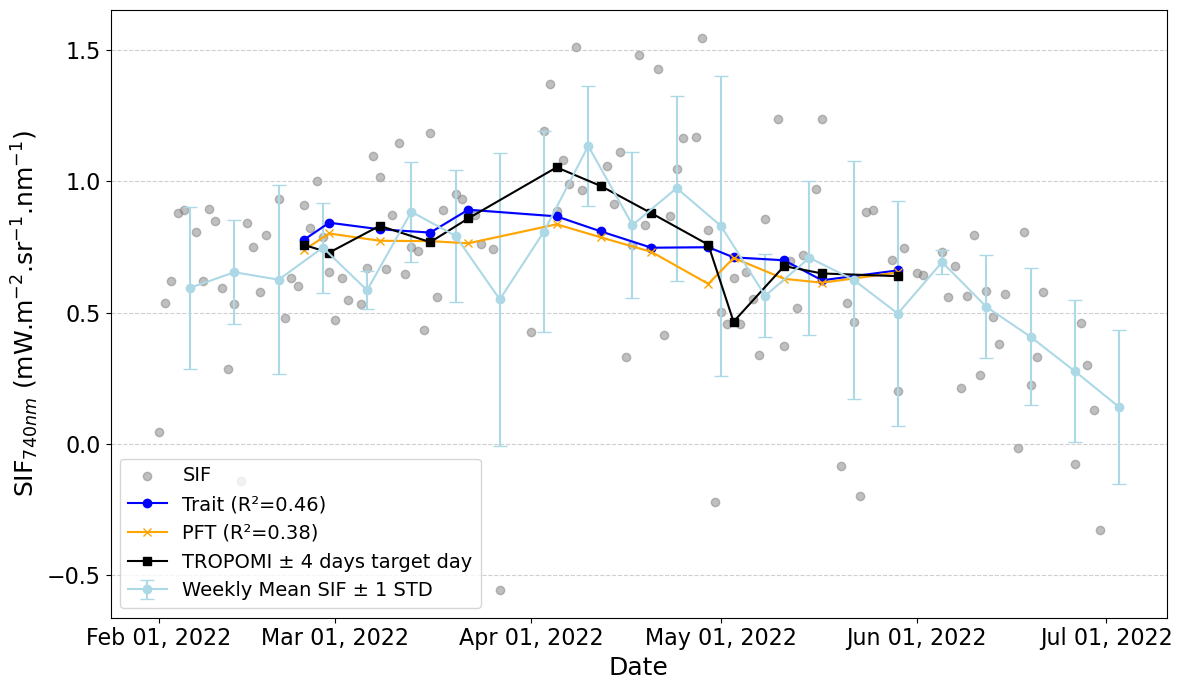

In [19]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress

# Function to calculate 95% confidence interval area
def calc_ci95_area(data):
    mean = np.nanmean(data, axis=(1, 2))
    std = np.nanstd(data, axis=(1, 2))
    count = np.sum(~np.isnan(data), axis=(1, 2))
    ci95_hi = mean + 1.96 * std / np.sqrt(count)
    ci95_lo = mean - 1.96 * std / np.sqrt(count)
    return ci95_lo, ci95_hi

# Load the modified NetCDF file
file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.005deg_regrid_Dangermond_tll_clipped.nc"
ds = xr.open_dataset(file_path)

# Handle missing values
ds['sif'] = ds['sif'].where(ds['sif'] != -999)

# Convert time to datetime objects using cftime for better handling of non-standard calendars and large values
ds['time'] = xr.cftime_range(start='2022-02-01', periods=len(ds['time']), freq='D', calendar='proleptic_gregorian')
ds['time'] = ds.indexes['time'].to_datetimeindex()

# Compute the mean SIF over all lat/lon for each time step
mean_sif = ds['sif'].mean(dim=['lat', 'lon'], skipna=True)

# Resample to weekly values and compute the mean and standard deviation
weekly_mean_sif = mean_sif.resample(time='W').mean()
weekly_std_sif = mean_sif.resample(time='W').std()

# Given target dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Convert target dates to datetime objects
target_dates = pd.to_datetime(dates)

# Calculate average SIF around each target date (3 days before and after)
average_sif_target_dates = []
for target_date in target_dates:
    start_date = target_date - pd.Timedelta(days=4)
    end_date = target_date + pd.Timedelta(days=4)
    mask = (ds['time'] >= start_date) & (ds['time'] <= end_date)
    average_sif_target_dates.append(mean_sif[mask].mean().item())

average_sif_target_dates = np.array(average_sif_target_dates)

# Plotting the first part
fig, ax = plt.subplots(figsize=(12, 7))

# Plot all original data points
ax.scatter(np.array(ds['time']), mean_sif, marker='o', linestyle='-', color='gray', alpha=0.5, label='SIF')

# Plot weekly average with standard deviation as error bars
ax.errorbar(np.array(weekly_mean_sif['time']), weekly_mean_sif, yerr=weekly_std_sif, fmt='o', color='lightblue', linestyle='-', capsize=5, label='Weekly Mean SIF ± 1 STD')

# Plot average SIF around target dates
#ax.plot(target_dates, average_sif_target_dates, marker='x', linestyle='-', color='red', label='Mean SIF around Target Dates')

# Now, add the second part of the plot

# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{}_clima_fit_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/pft_shift_fluxes_day_{}_clima_fit_reg_jmax.nc"

# Initialize lists to store data
mean_sif740_trait = []
mean_sif740_pft = []
ci95_hi_trait = []
ci95_lo_trait = []
ci95_hi_pft = []
ci95_lo_pft = []

# Convert string dates to pandas datetime objects
date_objects = pd.to_datetime(dates)

for i, date in enumerate(date_objects):
    file_trait = base_file_path_trait.format(str(i).zfill(2))
    file_pft = base_file_path_pft.format(str(i).zfill(2))

    # Open datasets
    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)

    # Calculate mean SIF740 and confidence interval area for Trait and PFT
    mean_sif740_trait.append(ds_trait['sif740'].mean(dim=['lat', 'lon']).values.item())
    mean_sif740_pft.append(ds_pft['sif740'].mean(dim=['lat', 'lon']).values.item())

    ci_lo_trait, ci_hi_trait = calc_ci95_area(ds_trait['sif740'].values)
    ci_lo_pft, ci_hi_pft = calc_ci95_area(ds_pft['sif740'].values)

    ci95_lo_trait.append(ci_lo_trait)
    ci95_hi_trait.append(ci_hi_trait)
    ci95_lo_pft.append(ci_lo_pft)
    ci95_hi_pft.append(ci_hi_pft)

# TROPOMI data two weeks 001
tropomi_sif = average_sif_target_dates.tolist()

# Calculate R^2 values
trait_r2 = linregress(mean_sif740_trait, tropomi_sif).rvalue ** 2
pft_r2 = linregress(mean_sif740_pft, tropomi_sif).rvalue ** 2

# Plotting the second part on the same figure
ax.plot(date_objects, mean_sif740_trait, label=f'Trait (R²={trait_r2:.2f})', marker='o', color='blue')
ax.plot(date_objects, mean_sif740_pft, label=f'PFT (R²={pft_r2:.2f})', marker='x', color='orange')
ax.plot(date_objects, tropomi_sif, label='TROPOMI ± 4 days target day', marker='s', color='black')

# Ensure that the ci95_lo and ci95_hi arrays are 1D by flattening them
ci95_lo_trait = np.array(ci95_lo_trait).flatten()
ci95_hi_trait = np.array(ci95_hi_trait).flatten()
ci95_lo_pft = np.array(ci95_lo_pft).flatten()
ci95_hi_pft = np.array(ci95_hi_pft).flatten()

# Add shaded area for ci95
ax.fill_between(date_objects, ci95_lo_trait, ci95_hi_trait, color='blue', alpha=0.1)
ax.fill_between(date_objects, ci95_lo_pft, ci95_hi_pft, color='orange', alpha=0.1)

# Formatting the plot
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel(r'SIF$_{740nm}$ (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Display month intervals on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Y"))  # Format x-axis date labels
ax.legend(loc='best', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Save the plot with high DPI for publication
plt.tight_layout()
#plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/mean_sif740_combined_over_time_clima_fit_pub_tropomi.png', dpi=300)
plt.show()


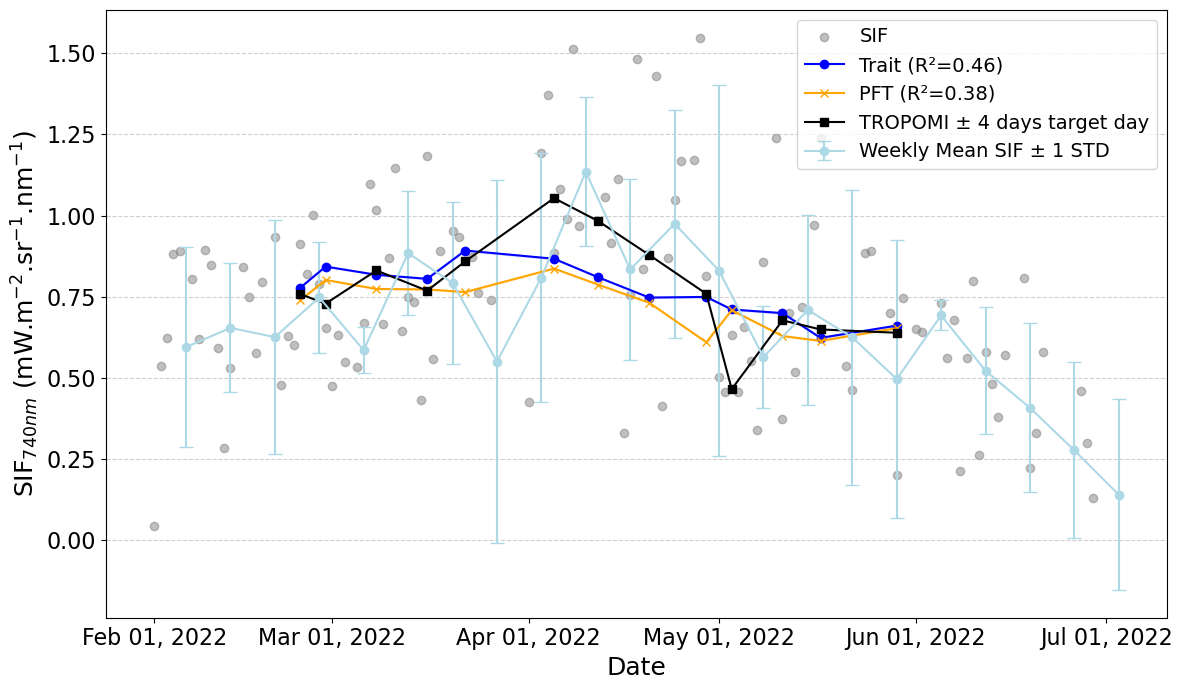

In [26]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress

# Function to calculate 95% confidence interval area
def calc_ci95_area(data):
    mean = np.nanmean(data, axis=(1, 2))
    std = np.nanstd(data, axis=(1, 2))
    count = np.sum(~np.isnan(data), axis=(1, 2))
    ci95_hi = mean + 1.96 * std / np.sqrt(count)
    ci95_lo = mean - 1.96 * std / np.sqrt(count)
    return ci95_lo, ci95_hi

# Load the modified NetCDF file
file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.005deg_regrid_Dangermond_tll_clipped.nc"
ds = xr.open_dataset(file_path)

# Handle missing values
ds['sif'] = ds['sif'].where(ds['sif'] != -999)

# Convert time to datetime objects using cftime for better handling of non-standard calendars and large values
ds['time'] = xr.cftime_range(start='2022-02-01', periods=len(ds['time']), freq='D', calendar='proleptic_gregorian')
ds['time'] = ds.indexes['time'].to_datetimeindex()

# Compute the mean SIF over all lat/lon for each time step
mean_sif = ds['sif'].mean(dim=['lat', 'lon'], skipna=True)

# Resample to weekly values and compute the mean and standard deviation
weekly_mean_sif = mean_sif.resample(time='W').mean()
weekly_std_sif = mean_sif.resample(time='W').std()

# Given target dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Convert target dates to datetime objects
target_dates = pd.to_datetime(dates)

# Calculate average SIF around each target date (3 days before and after)
average_sif_target_dates = []
for target_date in target_dates:
    start_date = target_date - pd.Timedelta(days=4)
    end_date = target_date + pd.Timedelta(days=4)
    mask = (ds['time'] >= start_date) & (ds['time'] <= end_date)
    average_sif_target_dates.append(mean_sif[mask].mean().item())

average_sif_target_dates = np.array(average_sif_target_dates)

# Plotting the first part
fig, ax = plt.subplots(figsize=(12, 7))

# Plot all original data points
positive_mean_sif = mean_sif.where(mean_sif > 0, np.nan)
ax.scatter(np.array(ds['time']), positive_mean_sif, marker='o', linestyle='-', color='gray', alpha=0.5, label='SIF')

# Plot weekly average with standard deviation as error bars
positive_weekly_mean_sif = weekly_mean_sif.where(weekly_mean_sif > 0, np.nan)
ax.errorbar(np.array(positive_weekly_mean_sif['time']), positive_weekly_mean_sif, yerr=weekly_std_sif, fmt='o', color='lightblue', linestyle='-', capsize=5, label='Weekly Mean SIF ± 1 STD')

# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{}_clima_fit_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/pft_shift_fluxes_day_{}_clima_fit_reg_jmax.nc"

# Initialize lists to store data
mean_sif740_trait = []
mean_sif740_pft = []
ci95_hi_trait = []
ci95_lo_trait = []
ci95_hi_pft = []
ci95_lo_pft = []

# Convert string dates to pandas datetime objects
date_objects = pd.to_datetime(dates)

for i, date in enumerate(date_objects):
    file_trait = base_file_path_trait.format(str(i).zfill(2))
    file_pft = base_file_path_pft.format(str(i).zfill(2))

    # Open datasets
    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)

    # Calculate mean SIF740 and confidence interval area for Trait and PFT
    mean_sif740_trait.append(ds_trait['sif740'].mean(dim=['lat', 'lon']).values.item())
    mean_sif740_pft.append(ds_pft['sif740'].mean(dim=['lat', 'lon']).values.item())

    ci_lo_trait, ci_hi_trait = calc_ci95_area(ds_trait['sif740'].values)
    ci_lo_pft, ci_hi_pft = calc_ci95_area(ds_pft['sif740'].values)

    ci95_lo_trait.append(ci_lo_trait)
    ci95_hi_trait.append(ci_hi_trait)
    ci95_lo_pft.append(ci_lo_pft)
    ci95_hi_pft.append(ci_hi_pft)

# TROPOMI data two weeks 001
tropomi_sif = average_sif_target_dates.tolist()

# Calculate R^2 values
trait_r2 = linregress(mean_sif740_trait, tropomi_sif).rvalue ** 2
pft_r2 = linregress(mean_sif740_pft, tropomi_sif).rvalue ** 2

# Plotting the second part on the same figure
ax.plot(date_objects, mean_sif740_trait, label=f'Trait (R²={trait_r2:.2f})', marker='o', color='blue')
ax.plot(date_objects, mean_sif740_pft, label=f'PFT (R²={pft_r2:.2f})', marker='x', color='orange')
ax.plot(date_objects, tropomi_sif, label='TROPOMI ± 4 days target day', marker='s', color='black')

# Ensure that the ci95_lo and ci95_hi arrays are 1D by flattening them
ci95_lo_trait = np.array(ci95_lo_trait).flatten()
ci95_hi_trait = np.array(ci95_hi_trait).flatten()
ci95_lo_pft = np.array(ci95_lo_pft).flatten()
ci95_hi_pft = np.array(ci95_hi_pft).flatten()

# Add shaded area for ci95
ax.fill_between(date_objects, ci95_lo_trait, ci95_hi_trait, color='blue', alpha=0.1)
ax.fill_between(date_objects, ci95_lo_pft, ci95_hi_pft, color='orange', alpha=0.1)

# Formatting the plot
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel(r'SIF$_{740nm}$ (mW.m$^{-2}$.sr$^{-1}$.nm$^{-1}$)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Display month intervals on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Y"))  # Format x-axis date labels
ax.legend(loc='best', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Save the plot with high DPI for publication
plt.tight_layout()
#plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/mean_sif740_combined_over_time_clima_fit_pub_tropomi.png', dpi=300)
plt.show()


# Plotting GPP

In [7]:
# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file path
#base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax.nc"
base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{}_clima_fit_reg_jmax.nc"

# Open the NetCDF file for TROPOMI dataset
file2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.001deg_regrid_Dangermond_tll_clipped_458_492.nc"
ds2 = xr.open_dataset(file2, decode_times=True)

# Save dates, mean, and std values to a text file
try:
    file = open('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/trait_statistics_hr.txt', 'w')
    file.write('Date\tMean Observed\tStd Observed\tCI95 Observed\tMean Predicted\tStd Predicted\tCI95 Predicted\n')
except Exception as e:
    print(f"Error: {e}")


# Initialize empty lists to accumulate data points
observed_all = []
predicted_all = []

# Initialize a list to store individual spatial differences
spatial_diff_list = []

for i, target_date_str in enumerate(dates):
    # Construct file1 dynamically based on the time step index (i)
    file1 = base_file_path.format(str(i).zfill(2))

    # Open dataset for file1
    ds1 = xr.open_dataset(file1, decode_times=False)  
    
    target_date = pd.Timestamp(target_date_str).value / 10**9  # Convert to seconds since epoch
    print('target_date=',target_date)
    # Convert target_date to datetime64[ns]
    target_date = pd.to_datetime(target_date, unit='s')
    print('target_date=',target_date)

    # Define a time range for a week centered around the target date
    start_date = target_date - pd.Timedelta(days=3)  # 3 days before the target date
    end_date = target_date + pd.Timedelta(days=3)    # 3 days after the target date

    # Select the data from the dataset with multiple times based on the specific date
    ds2_selected = ds2.sel(time=target_date, method="nearest")
    print(ds2_selected)
    
    # Select the data from ds2 within the specified time range
    ds2_selected = ds2.sel(time=slice(start_date, end_date))
    ds2_selected = ds2_selected.mean(dim='time', skipna=True)
    print(ds2_selected)
    #sys.exit()

    # Calculate the average time of the selected data in ds2_selected

    ds1_selected = ds1['gpp']
    
    # Filter out NaN values
    valid_indices = ~np.isnan(ds2_selected['sif'].values.flatten()) & ~np.isnan(ds1_selected.values.flatten())
    if valid_indices.any():
        observed = ds2_selected['sif'].values.flatten()[valid_indices]
        predicted = ds1_selected.values.flatten()[valid_indices]
        
        print("Observed shape before cleaning:", observed.shape)
        print("Predicted shape before cleaning:", predicted.shape)

        observed = observed[~np.isnan(observed)]
        predicted = predicted[~np.isnan(predicted)]

        print("Observed shape after cleaning:", observed.shape)
        print("Predicted shape after cleaning:", predicted.shape)


        print('mean obs =', np.mean(observed))
        print('mean pred =', np.mean(predicted))

        # Calculate spatial differences
        spatial_diff_num =  predicted 

        # Squeeze the array to remove the singleton dimension
        spatial_diff_num = np.squeeze(spatial_diff_num)   
        
        # Calculate spatial differences
        spatial_diff =  ds1_selected.values
        
        # Squeeze the array to remove the singleton dimension
        spatial_diff = np.squeeze(spatial_diff)
        
        
        # Calculate spatial differences and append them to the list
        spatial_diff_list.append(spatial_diff)

        #Get latitude and longitude values
        lat_values = ds2_selected['lat'].values
        lon_values = ds2_selected['lon'].values
        
        # Calculate metrics
        mae = mean_absolute_error(observed, predicted)

        # Calculate mean, std, bias, RMSE, and R²
        mean_observed = np.mean(observed)
        mean_predicted = np.mean(predicted)
        std_observed = np.std(observed)
        std_predicted = np.std(predicted)
        bias = mean_predicted - mean_observed
        rmse = np.sqrt(np.mean((predicted - observed)**2))
        slope, intercept, r_value, p_value, std_err = linregress(observed, predicted)
        r2 = r_value**2


        
        #plt.imshow(spatial_diff)
        #plt.colorbar()
        #plt.show()
        #plt.close()
        print("mae:", mae)
        print("bias:", bias)
        print("RMSE:", rmse)
        print("R^2 Score:", r2)

        # create 95% confidence interval 
        ci95_observed = st.t.interval(0.95, df=len(observed)-1, 
                        loc=np.mean(observed), 
                        scale=st.sem(observed)) 

        # create 95% confidence interval 
        ci95_predicted = st.t.interval(0.95, df=len(predicted)-1, 
                        loc=np.mean(predicted), 
                        scale=st.sem(predicted)) 
  
        # Append statistics for the current date to the file
        file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted}\t{bias}\t{rmse}\t{r2}\n')

        # Create a Basemap instance with the desired projection
        m = Basemap(projection='merc', llcrnrlat=lat_values.min(), urcrnrlat=lat_values.max(),
                llcrnrlon=lon_values.min(), urcrnrlon=lon_values.max(), resolution='c')

        x,y = np.meshgrid(lon_values, lat_values) 
        X,Y = m(x, y)
        
        # Define the number of decimal places for meridian and parallel labels
        decimal_places = 3

        # Define a custom formatter function to format the labels with the specified number of decimal places
        def format_labels(x, pos):
            return '{:.{decimal_places}f}'.format(x, decimal_places=decimal_places)


        # Create a figure and axes
        plt.figure(figsize=(8, 6))
        m.drawparallels(np.arange(-90.,91.,0.025), labels=[1,0,0,1],    dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        m.drawmeridians(np.arange(0., 360., 0.025), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        #m.drawcoastlines(color='0.6', linewidth=0.5)

        # Plot spatial differences using pcolormesh with Basemap
        cs = m.pcolormesh(X, Y, spatial_diff, cmap='YlGn', vmin=0, vmax=12.)

        vmin = 0.
        vmax = 12.
        cbar = m.colorbar(cs, pad='10%',ticks=np.linspace(vmin,vmax,6),format='%.2f')
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel(r'GPP ($\mu$mol CO$_{2}$.m$^{-2}$.s$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
        cbar.solids.set_edgecolor("face")
        #cbar.set_clim(vmin,vmax)
        # Assuming cbar is your Colorbar object
        #cbar.ax.set_clim(vmin, vmax)
        cbar.ax.tick_params(labelsize='large')
        #gdf.plot(ax=m, linewidth=1, edgecolor='black', facecolor='none', legend=True)
        #m.readshapefile(shapefile_path,'Geometry')
        # Plot contour of Dangermond shapefile
        #m.readshapefile(shapefile_path, 'dan_bound2', linewidth=2, color='black')
        
        # Manually draw shapefile polygons on top of the contour plot
        for shape in gdf['geometry']:
            if shape.geom_type == 'Polygon':
                x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
                polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
                plt.gca().add_patch(polygon)

        # Plot spatial differences with latitude and longitude values on the y and x axes
        #plt.imshow(spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data range
    
        # Overlay shapefile contour on top of the spatial differences plot
        #gdf.plot(ax=plt.gca(), linewidth=1, edgecolor='black', facecolor='none', legend=True)


        # Set title, labels, and tick formatters
        plt.title(f'Date {target_date_str}',fontsize=14)
        #plt.xlabel('Longitude')
        #plt.ylabel('Latitude')
    

        # Add colorbar to the right of the plot
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)


        
        # Set 2 decimal places for latitude and longitude ticks
        #lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lat_values[x]))
        #lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lon_values[x]))
        
        
        # Get latitude and longitude values from your SIF data
        #lat_min, lat_max = lat_values.min(), lat_values.max()
        #lon_min, lon_max = lon_values.min(), lon_values.max()
        #print( lon_min, lon_max,lat_min, lat_max)
        
        # Set 4 ticks for latitude and longitude
        #num_ticks = 4
        #lat_indices = np.linspace(0, len(lat_values) - 1, num_ticks, dtype=int)
        #lon_indices = np.linspace(0, len(lon_values) - 1, num_ticks, dtype=int)

        # Set x and y ticks with actual lat and lon values formatted to 2 decimal places
        #plt.xticks(lon_indices, lon_values[lon_indices])
        #plt.yticks(lat_indices, lat_values[lat_indices])

        # Set formatted latitude and longitude tick labels
        #plt.gca().get_xaxis().set_major_formatter(lon_formatter)
        #plt.gca().get_yaxis().set_major_formatter(lat_formatter)
        


        # Add text box with statistics in the upper right corner
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
        plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
                transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right',fontsize=14)
                


        # Invert the latitude axis
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        # Save the figure
        plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/gpp_{i}_hr_jmax_clima_fit.png',dpi=300)
        #plt.show()
        #sys.exit()
        
        # Close the figure to avoid displaying multiple plots at once
        plt.close()
        print('Figure spatial_differences_{i}.png saved!')
        

        # Filter out NaN values
        valid_indices = ~np.isnan(ds1_selected.values) & ~np.isnan(ds2_selected['sif'].values)
        observed = ds2_selected['sif'].values.reshape(-1)[valid_indices.reshape(-1)]
        predicted = ds1_selected.values.reshape(-1)[valid_indices.reshape(-1)]

        # Check if there are still valid values after filtering
        if len(observed) > 0 and len(predicted) > 0:
            # Accumulate observed and predicted values
            observed_all.extend(observed)
            predicted_all.extend(predicted)

        # Close the datasets to free up resources
        ds1.close()
        ds2_selected.close()
        
        print('Total matrix ammended!')
        print(spatial_diff_list)
    
    
# Calculate the average spatial difference after the loop
average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)  

# Create a figure and axes
plt.figure(figsize=(8, 6))
m.drawparallels(np.arange(-90., 91., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)
m.drawmeridians(np.arange(0., 360., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)

# Plot spatial differences using pcolormesh with Basemap
cs = m.pcolormesh(X, Y, average_spatial_diff, cmap='YlGn', vmin=0, vmax=12)

vmin = 0
vmax = 12
cbar = m.colorbar(cs, pad='10%', ticks=np.linspace(vmin, vmax, 6), format='%.2f')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'GPP ($\mu$mol CO$_{2}$.m$^{-2}$.s$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
cbar.solids.set_edgecolor("face")
cbar.ax.tick_params(labelsize='large')

# Manually draw shapefile polygons on top of the contour plot
for shape in gdf['geometry']:
    if shape.geom_type == 'Polygon':
       x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
       polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
       plt.gca().add_patch(polygon)

# Set title, labels, and tick formatters
plt.title(f'Mean', fontsize=14)

# Add text box with statistics in the upper right corner
bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
           transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right', fontsize=14)


plt.tight_layout()
# Save the figure
plt.savefig(f'/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/gpp_mean_hr_jmax.png', dpi=300)


# Close the figure to avoid displaying multiple plots at once
plt.close()
print(f'Figure pft_spatial_differences_{i}.png saved!')
  


target_date= 1645660800.0
target_date= 2022-02-24 00:00:00
<xarray.Dataset> Size: 9MB
Dimensions:         (lat: 458, lon: 492, nbnd: 2)
Coordinates:
  * lat             (lat) float64 4kB 34.44 34.44 34.44 ... 34.58 34.58 34.58
  * lon             (lon) float64 4kB -120.5 -120.5 -120.5 ... -120.4 -120.4
    time            datetime64[ns] 8B 2022-02-24
Dimensions without coordinates: nbnd
Data variables: (12/13)
    lat_bnds        (lat, nbnd) float64 7kB ...
    lon_bnds        (lon, nbnd) float64 8kB ...
    gw              (lat) float64 4kB ...
    area            (lat, lon) float64 2MB ...
    cloud_fraction  (lat, lon) float32 901kB ...
    dcCorr          (lat, lon) float32 901kB ...
    ...              ...
    phase_angle     (lat, lon) float32 901kB ...
    sif             (lat, lon) float32 901kB ...
    sif_dc          (lat, lon) float32 901kB ...
    sif_relative    (lat, lon) float32 901kB ...
    sif_sigma       (lat, lon) float32 901kB ...
    spatial_ref     int64 8B ...


/tmp/ipykernel_3131682/756746284.py:268: RuntimeWarning: Mean of empty slice
  average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)


Figure pft_spatial_differences_12.png saved!


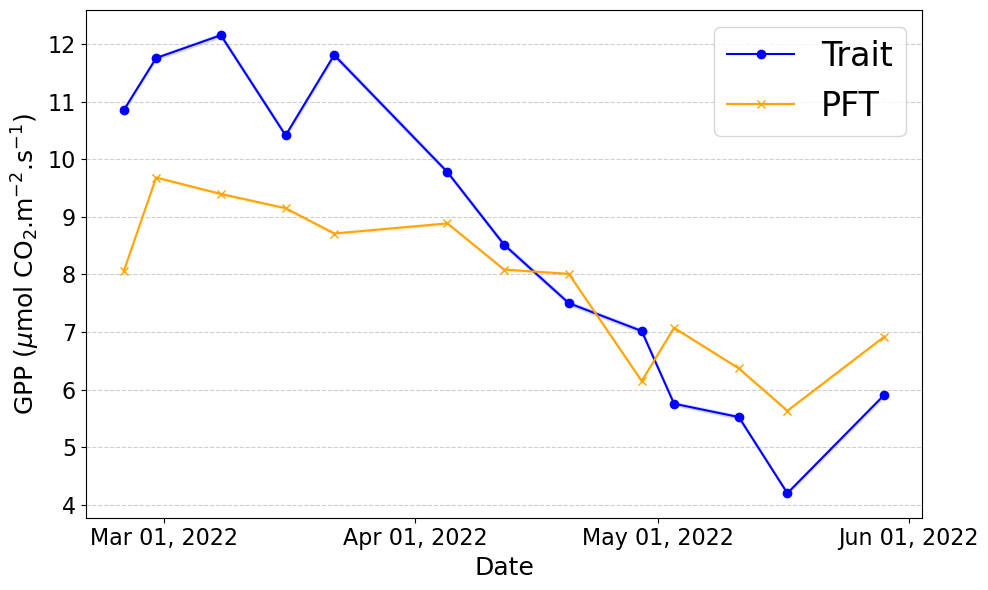

In [3]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Function to calculate standard deviation area
def calc_std_area(data):
    std_hi = []
    std_lo = []

    mean = np.nanmean(data, axis=(1, 2))
    std = np.nanstd(data, axis=(1, 2))
    std_hi = mean + std
    std_lo = mean - std
    return std_lo, std_hi

# Function to calculate the 95% confidence interval
def calc_ci95(data):
    mean = np.nanmean(data, axis=(1, 2))
    std = np.nanstd(data, axis=(1, 2))
    count = np.sum(~np.isnan(data), axis=(1, 2))
    ci95_hi = mean + 1.99 * std / np.sqrt(count)
    ci95_lo = mean - 1.99 * std / np.sqrt(count)
    return ci95_lo, ci95_hi


# Given dates
dates = [
    "2022-02-24", "2022-02-28", "2022-03-08",
    "2022-03-16", "2022-03-22", "2022-04-05",
    "2022-04-12", "2022-04-20", "2022-04-29",
    "2022-05-03", "2022-05-11", "2022-05-17",
    "2022-05-29"
]

# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{}_clima_fit_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/pft_shift_fluxes_day_{}_clima_fit_reg_jmax.nc"

# Initialize lists to store data
mean_sif740_trait = []
mean_sif740_pft = []
std_hi_trait = []
std_lo_trait = []
std_hi_pft = []
std_lo_pft = []
ci95_hi_trait = []
ci95_lo_trait = []
ci95_hi_pft = []
ci95_lo_pft = []

# Convert string dates to pandas datetime objects
date_objects = pd.to_datetime(dates)

for i, date in enumerate(date_objects):
    file_trait = base_file_path_trait.format(str(i).zfill(2))
    file_pft = base_file_path_pft.format(str(i).zfill(2))

    # Open datasets
    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)

    # Calculate mean SIF740 and standard deviation area for Trait and PFT
    mean_sif740_trait.append(ds_trait['gpp'].mean(dim=['lat', 'lon']).values)
    mean_sif740_pft.append(ds_pft['gpp'].mean(dim=['lat', 'lon']).values)

    std_lo, std_hi = calc_std_area(ds_trait['gpp'].values)
    std_lo_trait.append(std_lo)
    std_hi_trait.append(std_hi)

    std_lo, std_hi = calc_std_area(ds_pft['gpp'].values)
    std_lo_pft.append(std_lo)
    std_hi_pft.append(std_hi)

    ci_lo_trait, ci_hi_trait = calc_ci95(ds_trait['gpp'].values)
    ci_lo_pft, ci_hi_pft = calc_ci95(ds_pft['gpp'].values)

    ci95_lo_trait.append(ci_lo_trait)
    ci95_hi_trait.append(ci_hi_trait)
    ci95_lo_pft.append(ci_lo_pft)
    ci95_hi_pft.append(ci_hi_pft)



# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(date_objects, mean_sif740_trait, label='Trait', marker='o', color='blue')
ax.plot(date_objects, mean_sif740_pft, label='PFT', marker='x', color='orange')

# Ensure that the std_lo and std_hi arrays are 1D by flattening them
std_lo_trait = np.array(std_lo_trait).flatten()
std_hi_trait = np.array(std_hi_trait).flatten()
std_lo_pft = np.array(std_lo_pft).flatten()
std_hi_pft = np.array(std_hi_pft).flatten()

# Ensure that the ci95_lo and ci95_hi arrays are 1D by flattening them
ci95_lo_trait = np.array(ci95_lo_trait).flatten()
ci95_hi_trait = np.array(ci95_hi_trait).flatten()
ci95_lo_pft = np.array(ci95_lo_pft).flatten()
ci95_hi_pft = np.array(ci95_hi_pft).flatten()

# Add shaded area for STD
#ax.fill_between(date_objects, std_lo_trait, std_hi_trait, color='blue', alpha=0.1)
#ax.fill_between(date_objects, std_lo_pft, std_hi_pft, color='orange', alpha=0.1)

# Add shaded area for ci95
ax.fill_between(date_objects, ci95_lo_trait, ci95_hi_trait, color='blue', alpha=0.1)
ax.fill_between(date_objects, ci95_lo_pft, ci95_hi_pft, color='orange', alpha=0.1)

# Formatting the plot
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel(r'GPP ($\mu$mol CO$_{2}$.m$^{-2}$.s$^{-1}$)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Display month intervals on x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Y"))  # Format x-axis date labels
#ax.legend(loc='upper right', fontsize=24)
ax.legend(loc='best', fontsize=24)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Save the plot with high DPI for publication
plt.tight_layout()
plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/mean_gpp_over_time_clima_fit_pub.png', dpi=300)
plt.show()


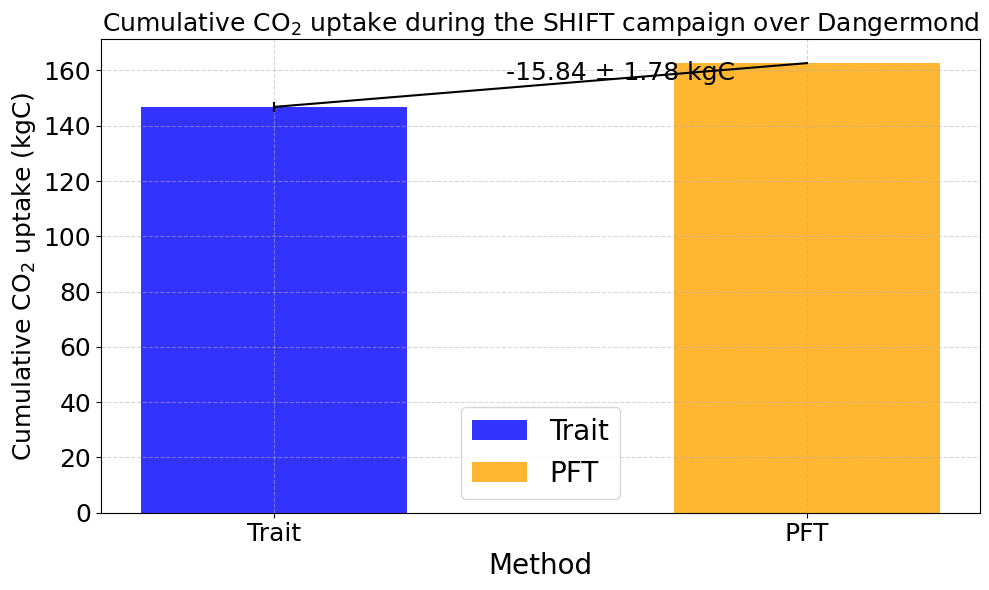

In [5]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Constants
AREA_HA = 9903  # Area of Dangermond Preserve in hectares
AREA_M2 = AREA_HA * 1e4  # Convert hectares to square meters
MOL_CO2_TO_KGC = 12.01 / 1e3 / 6.022e23 * 1e12  # Convert micromoles of CO2 to kilograms of C
seconds_per_day = 24 * 3600

# Given dates
dates = [
    "2022-02-24", "2022-02-28", "2022-03-08",
    "2022-03-16", "2022-03-22", "2022-04-05",
    "2022-04-12", "2022-04-20", "2022-04-29",
    "2022-05-03", "2022-05-11", "2022-05-17",
    "2022-05-29"
]

# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/shift_fluxes_day_{:02d}_clima_fit_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/fitted_prescribed_lai_ci/pft_shift_fluxes_day_{:02d}_clima_fit_reg_jmax.nc"

# Initialize lists to store GPP values for each dataset
gpp_values_trait = []
gpp_values_pft = []

# Convert string dates to pandas datetime objects
date_objects = pd.to_datetime(dates)

for i, date in enumerate(date_objects[:-1]):  # Exclude the last date since there's no next date to average with
    file_trait = base_file_path_trait.format(i + 1)
    file_pft = base_file_path_pft.format(i + 1)
    
    # Ensure that the next files exist
    next_file_trait = base_file_path_trait.format(i + 2 if i + 1 < len(date_objects) else i + 1)
    next_file_pft = base_file_path_pft.format(i + 2 if i + 1 < len(date_objects) else i + 1)

    if not os.path.exists(file_trait) or not os.path.exists(file_pft):
        print(f"File for date {date.strftime('%Y-%m-%d')} not found. Skipping to next date.")
        continue

    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)
    
    if os.path.exists(next_file_trait) and os.path.exists(next_file_pft):
        ds_next_trait = xr.open_dataset(next_file_trait, decode_times=False)
        ds_next_pft = xr.open_dataset(next_file_pft, decode_times=False)
    else:
        ds_next_trait = ds_trait  # Fallback to current file data
        ds_next_pft = ds_pft

    
    avg_gpp_trait = (ds_trait['gpp'].mean(dim=['lat', 'lon']).values + ds_next_trait['gpp'].mean(dim=['lat', 'lon']).values) / 2
    avg_gpp_pft = (ds_pft['gpp'].mean(dim=['lat', 'lon']).values + ds_next_pft['gpp'].mean(dim=['lat', 'lon']).values) / 2
    
    gpp_values_trait.append(avg_gpp_trait * seconds_per_day * AREA_M2 * MOL_CO2_TO_KGC)
    gpp_values_pft.append(avg_gpp_pft * seconds_per_day * AREA_M2 * MOL_CO2_TO_KGC)

#In 13 days (only with measurements)
cumulative_gpp_trait = np.sum(gpp_values_trait)
cumulative_gpp_pft = np.sum(gpp_values_pft)
std_uncertainty_trait = np.std(gpp_values_trait)
std_uncertainty_pft = np.std(gpp_values_pft)

#In (94 - 13) = 81 days (only with measurements)
# 81/13 = 6.23
cumulative_gpp_trait = np.sum(gpp_values_trait)*6.23
cumulative_gpp_pft = np.sum(gpp_values_pft)*6.23
std_uncertainty_trait = np.std(gpp_values_trait)*6.23
std_uncertainty_pft = np.std(gpp_values_pft)*6.23

difference = cumulative_gpp_trait - cumulative_gpp_pft
diff_uncertainty = np.sqrt(std_uncertainty_trait**2 + std_uncertainty_pft**2)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5
index = np.arange(2)
opacity = 0.8

ax.bar(index[0], cumulative_gpp_trait, bar_width, alpha=opacity, color='blue', yerr=std_uncertainty_trait, label='Trait')
ax.bar(index[1], cumulative_gpp_pft, bar_width, alpha=opacity, color='orange', yerr=std_uncertainty_pft, label='PFT')

# Formatting the plot
ax.set_xlabel('Method', fontsize=20)
ax.set_ylabel('Cumulative CO$_2$ uptake (kgC)', fontsize=18)
ax.set_title('Cumulative CO$_2$ uptake during the SHIFT campaign over Dangermond', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(['Trait', 'PFT'], fontsize=18)
ax.legend(fontsize=20)

# Customize grid lines
ax.grid(True, which='major', linestyle='--', alpha=0.5)

# Display the difference
ax.plot([index[0], index[1]], [cumulative_gpp_trait, cumulative_gpp_pft], 'k-')
ax.text(index.mean() + .15, (cumulative_gpp_trait + cumulative_gpp_pft) / 2, f'{difference:.2f} ± {diff_uncertainty:.2f} kgC', rotation=0, ha='center', va='bottom', fontsize=18)

# Increase y-axis tick font size
ax.tick_params(axis='y', labelsize=18)

# Save and show the plot
plt.tight_layout()
plt.savefig('/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/traits/figures/clima_fit_prescribed_lai_ci/cumulative_gpp_comparison_clima_fit.png', dpi=300)
plt.show()



# Plotting transp

In [20]:
# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]

# Base file path
#base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax.nc"
base_file_path = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax.nc"

# Open the NetCDF file for TROPOMI dataset
file2 = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/TROPOMI_dangermond/TROPOMI_SIF740nm-v1.001deg_regrid_Dangermond_tll_clipped_458_492.nc"
ds2 = xr.open_dataset(file2, decode_times=True)

# Save dates, mean, and std values to a text file
try:
    file = open('trait_statistics_hr.txt', 'w')
    file.write('Date\tMean Observed\tStd Observed\tCI95 Observed\tMean Predicted\tStd Predicted\tCI95 Predicted\n')
except Exception as e:
    print(f"Error: {e}")


# Initialize empty lists to accumulate data points
observed_all = []
predicted_all = []

# Initialize a list to store individual spatial differences
spatial_diff_list = []

for i, target_date_str in enumerate(dates):
    # Construct file1 dynamically based on the time step index (i)
    file1 = base_file_path.format(str(i).zfill(2))

    # Open dataset for file1
    ds1 = xr.open_dataset(file1, decode_times=False)  
    
    target_date = pd.Timestamp(target_date_str).value / 10**9  # Convert to seconds since epoch
    print('target_date=',target_date)
    # Convert target_date to datetime64[ns]
    target_date = pd.to_datetime(target_date, unit='s')
    print('target_date=',target_date)

    # Define a time range for a week centered around the target date
    start_date = target_date - pd.Timedelta(days=3)  # 3 days before the target date
    end_date = target_date + pd.Timedelta(days=3)    # 3 days after the target date

    # Select the data from the dataset with multiple times based on the specific date
    ds2_selected = ds2.sel(time=target_date, method="nearest")
    print(ds2_selected)
    
    # Select the data from ds2 within the specified time range
    ds2_selected = ds2.sel(time=slice(start_date, end_date))
    ds2_selected = ds2_selected.mean(dim='time', skipna=True)
    print(ds2_selected)
    #sys.exit()

    # Calculate the average time of the selected data in ds2_selected

    #From molH20m-2s-1 to mm.day-1
    #18 (mol to gram) * 1e-3 (gram to kg) * 1e-3 (kg to m3) * 1e3 (m to mm) * 24 * 3600
    ds1_selected = ds1['transp']*18.*1e-3*1e-3*1e3*24*3600
    
    
    # Filter out NaN values
    valid_indices = ~np.isnan(ds2_selected['sif'].values.flatten()) & ~np.isnan(ds1_selected.values.flatten())
    if valid_indices.any():
        observed = ds2_selected['sif'].values.flatten()[valid_indices]
        predicted = ds1_selected.values.flatten()[valid_indices]
        
        print("Observed shape before cleaning:", observed.shape)
        print("Predicted shape before cleaning:", predicted.shape)

        observed = observed[~np.isnan(observed)]
        predicted = predicted[~np.isnan(predicted)]

        print("Observed shape after cleaning:", observed.shape)
        print("Predicted shape after cleaning:", predicted.shape)


        print('mean obs =', np.mean(observed))
        print('mean pred =', np.mean(predicted))

        # Calculate spatial differences
        spatial_diff_num =  predicted 

        # Squeeze the array to remove the singleton dimension
        spatial_diff_num = np.squeeze(spatial_diff_num)   
        
        # Calculate spatial differences
        spatial_diff =  ds1_selected.values
        
        # Squeeze the array to remove the singleton dimension
        spatial_diff = np.squeeze(spatial_diff)
        
        
        # Calculate spatial differences and append them to the list
        spatial_diff_list.append(spatial_diff)

        #Get latitude and longitude values
        lat_values = ds2_selected['lat'].values
        lon_values = ds2_selected['lon'].values
        
        # Calculate metrics
        mae = mean_absolute_error(observed, predicted)

        # Calculate mean, std, bias, RMSE, and R²
        mean_observed = np.mean(observed)
        mean_predicted = np.mean(predicted)
        std_observed = np.std(observed)
        std_predicted = np.std(predicted)
        bias = mean_predicted - mean_observed
        rmse = np.sqrt(np.mean((predicted - observed)**2))
        slope, intercept, r_value, p_value, std_err = linregress(observed, predicted)
        r2 = r_value**2


        
        #plt.imshow(spatial_diff)
        #plt.colorbar()
        #plt.show()
        #plt.close()
        print("mae:", mae)
        print("bias:", bias)
        print("RMSE:", rmse)
        print("R^2 Score:", r2)

        # create 95% confidence interval 
        ci95_observed = st.t.interval(0.95, df=len(observed)-1, 
                        loc=np.mean(observed), 
                        scale=st.sem(observed)) 

        # create 95% confidence interval 
        ci95_predicted = st.t.interval(0.95, df=len(predicted)-1, 
                        loc=np.mean(predicted), 
                        scale=st.sem(predicted)) 
  
        # Append statistics for the current date to the file
        file.write(f'{target_date_str}\t{mean_observed}\t{std_observed}\t{ci95_observed}\t{mean_predicted}\t{std_predicted}\t{ci95_predicted}\t{bias}\t{rmse}\t{r2}\n')

        # Create a Basemap instance with the desired projection
        m = Basemap(projection='merc', llcrnrlat=lat_values.min(), urcrnrlat=lat_values.max(),
                llcrnrlon=lon_values.min(), urcrnrlon=lon_values.max(), resolution='c')

        x,y = np.meshgrid(lon_values, lat_values) 
        X,Y = m(x, y)
        
        # Define the number of decimal places for meridian and parallel labels
        decimal_places = 3

        # Define a custom formatter function to format the labels with the specified number of decimal places
        def format_labels(x, pos):
            return '{:.{decimal_places}f}'.format(x, decimal_places=decimal_places)


        # Create a figure and axes
        plt.figure(figsize=(8, 6))
        m.drawparallels(np.arange(-90.,91.,0.025), labels=[1,0,0,1],    dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        m.drawmeridians(np.arange(0., 360., 0.025), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=8)
        #m.drawcoastlines(color='0.6', linewidth=0.5)

        # Plot spatial differences using pcolormesh with Basemap
        cs = m.pcolormesh(X, Y, spatial_diff, cmap='YlGnBu', vmin=0, vmax=6.)

        vmin = 0.
        vmax = 6.
        cbar = m.colorbar(cs, pad='10%',ticks=np.linspace(vmin,vmax,6),format='%.2f')
        cbar.ax.get_yaxis().labelpad = 10
        cbar.ax.set_ylabel(r'ET (mm.day$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
        cbar.solids.set_edgecolor("face")
        #cbar.set_clim(vmin,vmax)
        # Assuming cbar is your Colorbar object
        #cbar.ax.set_clim(vmin, vmax)
        cbar.ax.tick_params(labelsize='large')
        #gdf.plot(ax=m, linewidth=1, edgecolor='black', facecolor='none', legend=True)
        #m.readshapefile(shapefile_path,'Geometry')
        # Plot contour of Dangermond shapefile
        #m.readshapefile(shapefile_path, 'dan_bound2', linewidth=2, color='black')
        
        # Manually draw shapefile polygons on top of the contour plot
        for shape in gdf['geometry']:
            if shape.geom_type == 'Polygon':
                x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
                polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
                plt.gca().add_patch(polygon)

        # Plot spatial differences with latitude and longitude values on the y and x axes
        #plt.imshow(spatial_diff, cmap='coolwarm', vmin=-1, vmax=1)  # Adjust vmin and vmax according to your data range
    
        # Overlay shapefile contour on top of the spatial differences plot
        #gdf.plot(ax=plt.gca(), linewidth=1, edgecolor='black', facecolor='none', legend=True)


        # Set title, labels, and tick formatters
        plt.title(f'Date {target_date_str}',fontsize=14)
        #plt.xlabel('Longitude')
        #plt.ylabel('Latitude')
    

        # Add colorbar to the right of the plot
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.1)


        
        # Set 2 decimal places for latitude and longitude ticks
        #lat_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lat_values[x]))
        #lon_formatter = ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(lon_values[x]))
        
        
        # Get latitude and longitude values from your SIF data
        #lat_min, lat_max = lat_values.min(), lat_values.max()
        #lon_min, lon_max = lon_values.min(), lon_values.max()
        #print( lon_min, lon_max,lat_min, lat_max)
        
        # Set 4 ticks for latitude and longitude
        #num_ticks = 4
        #lat_indices = np.linspace(0, len(lat_values) - 1, num_ticks, dtype=int)
        #lon_indices = np.linspace(0, len(lon_values) - 1, num_ticks, dtype=int)

        # Set x and y ticks with actual lat and lon values formatted to 2 decimal places
        #plt.xticks(lon_indices, lon_values[lon_indices])
        #plt.yticks(lat_indices, lat_values[lat_indices])

        # Set formatted latitude and longitude tick labels
        #plt.gca().get_xaxis().set_major_formatter(lon_formatter)
        #plt.gca().get_yaxis().set_major_formatter(lat_formatter)
        


        # Add text box with statistics in the upper right corner
        bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
        plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
                transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right',fontsize=14)
                


        # Invert the latitude axis
        #plt.gca().invert_yaxis()
        plt.tight_layout()
        # Save the figure
        plt.savefig(f'trans_{i}_hr_jmax.png',dpi=300)
        #plt.show()
        #sys.exit()
        
        # Close the figure to avoid displaying multiple plots at once
        plt.close()
        print('Figure spatial_differences_{i}.png saved!')
        

        # Filter out NaN values
        valid_indices = ~np.isnan(ds1_selected.values) & ~np.isnan(ds2_selected['sif'].values)
        observed = ds2_selected['sif'].values.reshape(-1)[valid_indices.reshape(-1)]
        predicted = ds1_selected.values.reshape(-1)[valid_indices.reshape(-1)]

        # Check if there are still valid values after filtering
        if len(observed) > 0 and len(predicted) > 0:
            # Accumulate observed and predicted values
            observed_all.extend(observed)
            predicted_all.extend(predicted)

        # Close the datasets to free up resources
        ds1.close()
        ds2_selected.close()
        
        print('Total matrix ammended!')
        print(spatial_diff_list)
    
    
# Calculate the average spatial difference after the loop
average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)  

# Create a figure and axes
plt.figure(figsize=(8, 6))
m.drawparallels(np.arange(-90., 91., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)
m.drawmeridians(np.arange(0., 360., 0.025), labels=[1, 0, 0, 1], dashes=[1, 1], linewidth=0.25, color='0.5', fontsize=8)

# Plot spatial differences using pcolormesh with Basemap
cs = m.pcolormesh(X, Y, average_spatial_diff, cmap='YlGnBu', vmin=0, vmax=6)

vmin = 0
vmax = 6
cbar = m.colorbar(cs, pad='10%', ticks=np.linspace(vmin, vmax, 6), format='%.2f')
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel(r'ET (mm.day$^{-1}$)', rotation=270, verticalalignment='center', color='black', size=16)
cbar.solids.set_edgecolor("face")
cbar.ax.tick_params(labelsize='large')

# Manually draw shapefile polygons on top of the contour plot
for shape in gdf['geometry']:
    if shape.geom_type == 'Polygon':
       x, y = m(shape.exterior.coords.xy[0], shape.exterior.coords.xy[1])
       polygon = Polygon(list(zip(x, y)), edgecolor='black', linewidth=1.5, facecolor='none')
       plt.gca().add_patch(polygon)

# Set title, labels, and tick formatters
plt.title(f'Mean', fontsize=14)

# Add text box with statistics in the upper right corner
bbox_props = dict(boxstyle="round,pad=0.8", facecolor="white", edgecolor="black", linewidth=0.5)
plt.gca().text(0.95, 0.95, f'Mean: {mean_predicted:.2f}\nSTD: {std_predicted:.2f}',
           transform=plt.gca().transAxes, bbox=bbox_props, verticalalignment='top', horizontalalignment='right', fontsize=14)


plt.tight_layout()
# Save the figure
plt.savefig(f'trans_mean_hr_jmax.png', dpi=300)


# Close the figure to avoid displaying multiple plots at once
plt.close()
print(f'Figure pft_spatial_differences_{i}.png saved!')
  


target_date= 1645660800.0
target_date= 2022-02-24 00:00:00
<xarray.Dataset>
Dimensions:         (lat: 458, lon: 492, nbnd: 2)
Coordinates:
  * lat             (lat) float64 34.44 34.44 34.44 34.44 ... 34.58 34.58 34.58
  * lon             (lon) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4 -120.4
    time            datetime64[ns] 2022-02-24
Dimensions without coordinates: nbnd
Data variables: (12/13)
    lat_bnds        (lat, nbnd) float64 ...
    lon_bnds        (lon, nbnd) float64 ...
    gw              (lat) float64 ...
    area            (lat, lon) float64 ...
    cloud_fraction  (lat, lon) float32 ...
    dcCorr          (lat, lon) float32 ...
    ...              ...
    phase_angle     (lat, lon) float32 ...
    sif             (lat, lon) float32 ...
    sif_dc          (lat, lon) float32 ...
    sif_relative    (lat, lon) float32 ...
    sif_sigma       (lat, lon) float32 ...
    spatial_ref     int64 ...
Attributes:
    title:           Awesome gridded file
    spatial_ref

<xarray.Dataset>
Dimensions:         (lat: 458, lon: 492, nbnd: 2)
Coordinates:
  * lat             (lat) float64 34.44 34.44 34.44 34.44 ... 34.58 34.58 34.58
  * lon             (lon) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4 -120.4
Dimensions without coordinates: nbnd
Data variables: (12/13)
    lat_bnds        (lat, nbnd) float64 34.44 34.44 34.44 ... 34.58 34.58 34.58
    lon_bnds        (lon, nbnd) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4
    gw              (lat) float64 4.292e-06 4.292e-06 ... 4.285e-06 4.285e-06
    area            (lat, lon) float64 2.234e-11 2.234e-11 ... 2.23e-11 2.23e-11
    cloud_fraction  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dcCorr          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    ...              ...
    phase_angle     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif             (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif_dc          (lat, lon) float32 n

<xarray.Dataset>
Dimensions:         (lat: 458, lon: 492, nbnd: 2)
Coordinates:
  * lat             (lat) float64 34.44 34.44 34.44 34.44 ... 34.58 34.58 34.58
  * lon             (lon) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4 -120.4
Dimensions without coordinates: nbnd
Data variables: (12/13)
    lat_bnds        (lat, nbnd) float64 34.44 34.44 34.44 ... 34.58 34.58 34.58
    lon_bnds        (lon, nbnd) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4
    gw              (lat) float64 4.292e-06 4.292e-06 ... 4.285e-06 4.285e-06
    area            (lat, lon) float64 2.234e-11 2.234e-11 ... 2.23e-11 2.23e-11
    cloud_fraction  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dcCorr          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    ...              ...
    phase_angle     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif             (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif_dc          (lat, lon) float32 n

<xarray.Dataset>
Dimensions:         (lat: 458, lon: 492, nbnd: 2)
Coordinates:
  * lat             (lat) float64 34.44 34.44 34.44 34.44 ... 34.58 34.58 34.58
  * lon             (lon) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4 -120.4
Dimensions without coordinates: nbnd
Data variables: (12/13)
    lat_bnds        (lat, nbnd) float64 34.44 34.44 34.44 ... 34.58 34.58 34.58
    lon_bnds        (lon, nbnd) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4
    gw              (lat) float64 4.292e-06 4.292e-06 ... 4.285e-06 4.285e-06
    area            (lat, lon) float64 2.234e-11 2.234e-11 ... 2.23e-11 2.23e-11
    cloud_fraction  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dcCorr          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    ...              ...
    phase_angle     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif             (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif_dc          (lat, lon) float32 n

<xarray.Dataset>
Dimensions:         (lat: 458, lon: 492, nbnd: 2)
Coordinates:
  * lat             (lat) float64 34.44 34.44 34.44 34.44 ... 34.58 34.58 34.58
  * lon             (lon) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4 -120.4
Dimensions without coordinates: nbnd
Data variables: (12/13)
    lat_bnds        (lat, nbnd) float64 34.44 34.44 34.44 ... 34.58 34.58 34.58
    lon_bnds        (lon, nbnd) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4
    gw              (lat) float64 4.292e-06 4.292e-06 ... 4.285e-06 4.285e-06
    area            (lat, lon) float64 2.234e-11 2.234e-11 ... 2.23e-11 2.23e-11
    cloud_fraction  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dcCorr          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    ...              ...
    phase_angle     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif             (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif_dc          (lat, lon) float32 n

<xarray.Dataset>
Dimensions:         (lat: 458, lon: 492, nbnd: 2)
Coordinates:
  * lat             (lat) float64 34.44 34.44 34.44 34.44 ... 34.58 34.58 34.58
  * lon             (lon) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4 -120.4
Dimensions without coordinates: nbnd
Data variables: (12/13)
    lat_bnds        (lat, nbnd) float64 34.44 34.44 34.44 ... 34.58 34.58 34.58
    lon_bnds        (lon, nbnd) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4
    gw              (lat) float64 4.292e-06 4.292e-06 ... 4.285e-06 4.285e-06
    area            (lat, lon) float64 2.234e-11 2.234e-11 ... 2.23e-11 2.23e-11
    cloud_fraction  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dcCorr          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    ...              ...
    phase_angle     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif             (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif_dc          (lat, lon) float32 n

<xarray.Dataset>
Dimensions:         (lat: 458, lon: 492, nbnd: 2)
Coordinates:
  * lat             (lat) float64 34.44 34.44 34.44 34.44 ... 34.58 34.58 34.58
  * lon             (lon) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4 -120.4
Dimensions without coordinates: nbnd
Data variables: (12/13)
    lat_bnds        (lat, nbnd) float64 34.44 34.44 34.44 ... 34.58 34.58 34.58
    lon_bnds        (lon, nbnd) float64 -120.5 -120.5 -120.5 ... -120.4 -120.4
    gw              (lat) float64 4.292e-06 4.292e-06 ... 4.285e-06 4.285e-06
    area            (lat, lon) float64 2.234e-11 2.234e-11 ... 2.23e-11 2.23e-11
    cloud_fraction  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    dcCorr          (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    ...              ...
    phase_angle     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif             (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    sif_dc          (lat, lon) float32 n

/tmp/ipykernel_1219210/3642727907.py:271: RuntimeWarning: Mean of empty slice
  average_spatial_diff = np.nanmean(spatial_diff_list, axis=0)


Figure pft_spatial_differences_12.png saved!


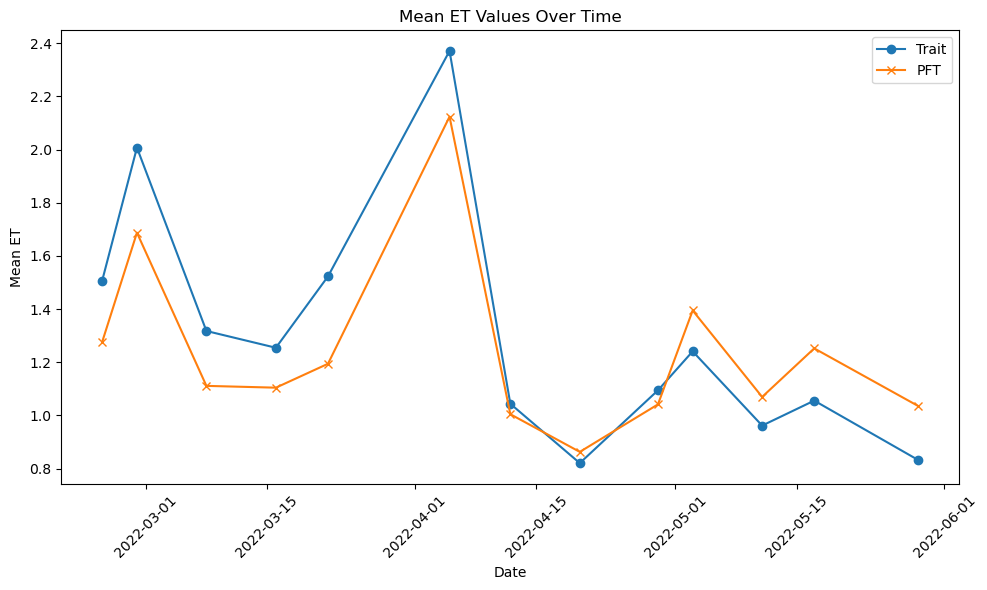

In [25]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Given dates
dates = ["2022-02-24T00:00:00.000000", "2022-02-28T00:00:00.000000", "2022-03-08T00:00:00.000000",
         "2022-03-16T00:00:00.000000", "2022-03-22T00:00:00.000000", "2022-04-05T00:00:00.000000",
         "2022-04-12T00:00:00.000000", "2022-04-20T00:00:00.000000", "2022-04-29T00:00:00.000000",
         "2022-05-03T00:00:00.000000", "2022-05-11T00:00:00.000000", "2022-05-17T00:00:00.000000",
         "2022-05-29T00:00:00.000000"]


# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{}_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/pft_shift_fluxes_day_{}_jmax.nc"

# Initialize lists to store mean Chl values for each dataset
mean_chl_trait = []
mean_chl_pft = []

# Convert string dates to pandas datetime objects
date_objects = [pd.to_datetime(date) for date in dates]

for i, date in enumerate(date_objects):
    file_trait = base_file_path_trait.format(str(i).zfill(2))
    file_pft = base_file_path_pft.format(str(i).zfill(2))

    # Open datasets
    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)

    # Extract Chl data and calculate mean, ignoring NaN values
    mean_chl_trait.append(ds_trait['transp'].mean().values*18.*1e-3*1e-3*1e3*24*3600)
    mean_chl_pft.append(ds_pft['transp'].mean().values*18.*1e-3*1e-3*1e3*24*3600)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(date_objects, mean_chl_trait, label='Trait', marker='o')
plt.plot(date_objects, mean_chl_pft, label='PFT', marker='x')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Mean ET')
plt.title('Mean ET Values Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('mean_et_over_time.png')
plt.show()


In [ ]:
# Calculate mean absolute difference and R^2 score for all accumulated data points
mean_abs_diff = np.mean(np.abs(np.array(predicted_all) - np.array(observed_all)))
#r2 = r2_score(np.array(observed_all), np.array(predicted_all))
# Calculate Pearson correlation coefficient
pearson_corr, _ = pearsonr(np.array(observed_all), np.array(predicted_all))

# Calculate R^2
r2 = pearson_corr**2

print("Mean Absolute Difference:", mean_abs_diff)
print("R^2 Score:", r2)

# Create a scatter plot for all accumulated data points
plt.figure(figsize=(8, 6))
plt.scatter(observed_all, predicted_all, color='blue', label='Observed vs Predicted')
plt.plot(observed_all, observed_all, color='red', linestyle='--', label='Perfect Fit')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_all, predicted_all)

# Assuming observed_all is a list
observed_all = np.array(observed_all)
predicted_all = np.array(predicted_all)

# Calculate fitted values using the regression equation
fitted_values = intercept + slope * observed_all

# Calculate MAE, bias, RMSE, and R²
mae = mean_absolute_error(observed_all, predicted_all)
bias = np.mean(predicted_all - observed_all)
rmse = np.sqrt(np.mean((predicted_all - observed_all)**2))
r2 = r_value**2

# Fit the linear regression model using statsmodels for AIC and BIC
X = sm.add_constant(observed_all)  # Add a constant term to the predictor
model = sm.OLS(predicted_all, X).fit()

# Get AIC and BIC
aic = model.aic
bic = model.bic

print(aic,bic)

# Plot the regression line
plt.plot(observed_all, fitted_values, color='green', label='Fitted Line')

# Display bias, RMSE, and R² on the plot
plt.text(0.1, 0.9, f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}\nAIC: {aic:.2f}\nBIC: {bic:.2f}', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8'))

print(f'Bias: {bias:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}\nMAE: {mae:.2f}\nAIC: {aic:.2f}\nBIC: {bic:.2f}')

plt.title('Observed vs Predicted SIF Values')
plt.xlabel('Observed SIF')
plt.ylabel('Predicted SIF')
plt.legend()
plt.grid(True)
plt.savefig(f'scatter_plot_all_trait_hr.png')
plt.close()


file.close()
